# Leg reversion study
---

In [89]:
from data_pre_processing import *
from pair_finder import *
from back_tester import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import os



## Data
---

In [90]:

#BTC and WBTC
#-------------------------------------------
#prices = pd.read_csv("binance_data/Wrapped BTC/2024/1m/merged_closing_prices.csv", index_col=0, parse_dates=True)


#SOL and BNSOL
#-------------------------------------------
#prices = pd.read_csv('binance_data/SOL_and_BNSOL/2025/1m/merged_closing_prices.csv', index_col=0, parse_dates=True)

#ETH and WBTC
#-------------------------------------------
prices = pd.read_csv('binance_data/ETH_and_WBETH/2024/1m/merged_closing_prices.csv', index_col=0, parse_dates=True)

#Top 100
#-------------------------------------------
#prices = pd.read_csv('binance_data/top_100_tickers/2024/1m/merged_closing_prices.csv', index_col=0, parse_dates=True)

In [91]:
#prices = prices[['XRP/USDT_2024_1m', 'ADA/USDT_2024_1m']]

#prices = prices[['DOT/USDT_2024_1m', 'XTZ/USDT_2024_1m']]

#BCH/USDT_2024_1m & DOGE/USDT_2024_1m
#-------------------------------------------
#prices = prices[['BCH/USDT_2024_1m', 'DOGE/USDT_2024_1m']]

#GALA/USDT_2024_1m & GRT/USDT_2024_1m,0.0056584346126191745,-4.071777010162084
#-------------------------------------------
#prices = prices[['GALA/USDT_2024_1m', 'GRT/USDT_2024_1m']]

In [92]:
#Filter prices from January 2024 to March 2024
#-------------------------------------------

prices = prices.loc['2024-01-01':'2024-06-30']


## Params
---

In [93]:
#Params:
window_size = 1440
entry_threshold= 3 #3 was prev
exit_threshold= 0
stop_loss_threshold = 100

## Investigation
---

In [94]:
sym1, sym2 = prices.columns
print(f"\nTesting strategy on pair: {sym1} and {sym2} ...")
S1 = prices[sym1]
S2 = prices[sym2]

# Compute the spread series and beta_series 
spread_series, beta_series, alpha_series = compute_spread_series(S1, S2, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series, rolling_mean, rolling_std = compute_rolling_zscore(spread_series, window_size)

#                                   FOR CLOSING PRICE DATA
#------------------------------------------------------------------------------------------
# Generate trading signals (positions) based on the spread's z-score
positions, trade_entries, trade_exits = backtest_pair_rolling(spread_series,S1,S2,zscore_series, entry_threshold, exit_threshold, stop_loss_threshold)



Testing strategy on pair: WBETH/USDT_2024_1m and ETH/USDT_2024_1m ...
Total trades closed: 1779 (Wins=1779, Losses=0)
Win rate: 1.00


In [95]:
initial_capital = 10_000.0
#tx_cost= 0.00031 #0.031% transaction cost
tx_cost= 0.00025 #0.025% transaction cost #Binance level 5 Maker Cost

trade_profits, net_trade_profits_S1, net_trade_profits_S2,cumulative_profit_series, entry_times, exit_times = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series, tx_cost)

Trade Num: 0
-----------------------------------------------
Trade type: -1, Entry time: 2024-01-03 00:03:00, Exit time: 2024-01-03 00:05:00
Net Trade profit (includes fees): 29.31315034386342
Beta at entry (Not the absolute value): 1.0081901958875625
Notional S1: 4979.608017446916, Notional S2: 5020.391982553083, Shares S1 : 2.0483784522611748, Shares S2: 2.1285203624786773
Percentage change S1: -0.73%, Percentage change S2: -0.04%
Trade Num: 1
-----------------------------------------------
Trade type: -1, Entry time: 2024-01-03 00:09:00, Exit time: 2024-01-03 00:17:00
Net Trade profit (includes fees): 12.106282306189843
Beta at entry (Not the absolute value): 1.0060829078156188
Notional S1: 4984.838842422912, Notional S2: 5015.161157577087, Shares S1 : 2.0561632619281585, Shares S2: 2.124870205988038
Percentage change S1: -0.32%, Percentage change S2: 0.02%
Trade Num: 2
-----------------------------------------------
Trade type: -1, Entry time: 2024-01-03 00:25:00, Exit time: 2024-0

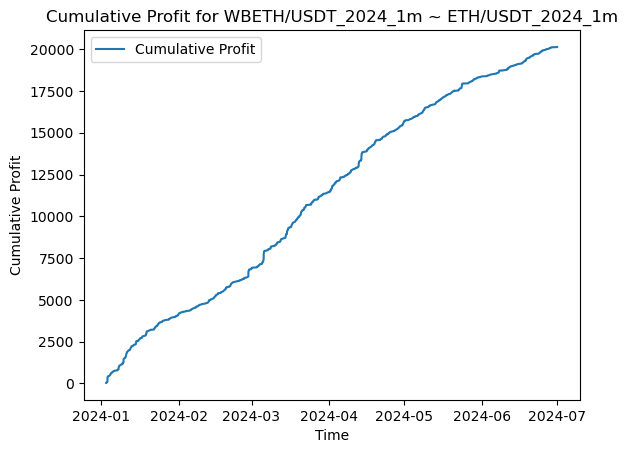

In [96]:
plt.plot(cumulative_profit_series, label='Cumulative Profit')
plt.title(f"Cumulative Profit for {sym1} ~ {sym2}")
plt.xlabel('Time')
plt.ylabel('Cumulative Profit')
plt.legend()

#Save the plot to the results folder for this pair. Create the folder if it doesn't exist.
if not os.path.exists(f"results/{sym1}_{sym2}"):
    os.makedirs(f"results/{sym1}_{sym2}")
#Save the plot
plt.savefig(f"results/{sym1}_{sym2}/cumulative_profit.png", dpi=300)

In [97]:
#Compute non-stop loss win rate

trade_losses = [profit for profit in trade_profits if profit < 0]
trade_wins = [profit for profit in trade_profits if profit > 0]
non_stop_loss_win_rate = len(trade_wins) / (len(trade_wins) + len(trade_losses)) * 100



if(stop_loss_threshold > 50):

    print(f"Average trade wins: {np.mean(trade_wins):.2f}")
    print(f"Average trade losses: {np.mean(trade_losses):.2f}")
    print(f"Number of wins: {len(trade_wins)}")
    print(f"Number of losses: {len(trade_losses)}")
    print(f"Non-stop loss win rate: {non_stop_loss_win_rate:.2f}%")



Average trade wins: 11.34
Average trade losses: -19.84
Number of wins: 1778
Number of losses: 1
Non-stop loss win rate: 99.94%


In [98]:
trade_durations = [(exit - entry).total_seconds() / 60 for entry, exit in zip(entry_times, exit_times)]

In [99]:
#Percentage changes in S1 and S2 each trade
trade_percentage_changes = []
for entry_time, exit_time in zip(entry_times, exit_times):
    # Calculate percentage change for S1 and S2
    price_change_S1 = (S1[exit_time] - S1[entry_time]) / S1[entry_time] * 100
    price_change_S2 = (S2[exit_time] - S2[entry_time]) / S2[entry_time] * 100
    trade_percentage_changes.append((price_change_S1, price_change_S2))

#Average absolute percentage change in S1 and S2
average_absolute_percentage_changes = [abs(s1+s2)/2 for s1, s2 in trade_percentage_changes]

#Compute abs trade profits 
abs_trade_profits = [abs(profit) for profit in trade_profits]
#Compute average trade profits

Correlation between average absolute percentage changes and absolute trade profits: 0.3581


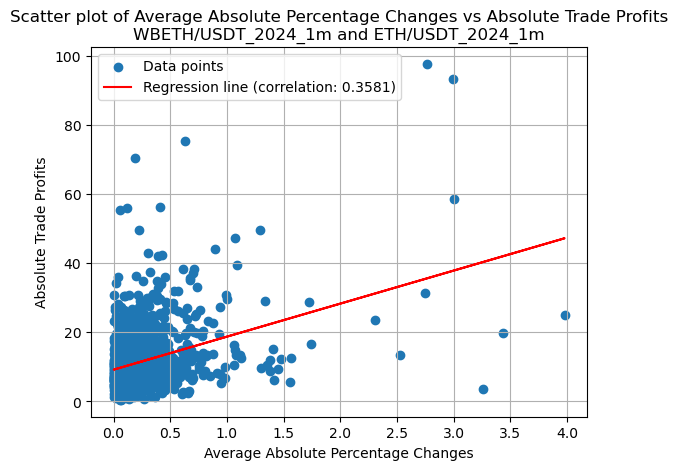

In [100]:
#Scatter plot for average_absolute_percentage_changes vs abs_trade_profits with regression line

# Fit a linear regression model


#Compute correlation between average_absolute_percentage_changes and abs_trade_profits
correlation = np.corrcoef(average_absolute_percentage_changes, abs_trade_profits)[0, 1]
print(f"Correlation between average absolute percentage changes and absolute trade profits: {correlation:.4f}")

X = np.array(average_absolute_percentage_changes).reshape(-1, 1)
y = np.array(abs_trade_profits)
model = LinearRegression()
model.fit(X, y)
# Predict y values
y_pred = model.predict(X)
# Plot the scatter plot with regression line
plt.scatter(average_absolute_percentage_changes, abs_trade_profits, label='Data points')
plt.plot(average_absolute_percentage_changes, y_pred, color='red', label='Regression line (correlation: {:.4f})'.format(correlation))
plt.xlabel('Average Absolute Percentage Changes')
plt.ylabel('Absolute Trade Profits')
plt.title(f'Scatter plot of Average Absolute Percentage Changes vs Absolute Trade Profits\n{sym1} and {sym2}')
#Add correlation to the legend

plt.legend()
plt.grid()

#Save the plot to the results folder for this pair. Create the folder if it doesn't exist.
if not os.path.exists(f"results/{sym1}_{sym2}"):
    os.makedirs(f"results/{sym1}_{sym2}")
#Save the plot
plt.savefig(f"results/{sym1}_{sym2}/Average_Absolute_Percent_Changes_Vs_Absolute_Trade_Profits.png", dpi=300)







In [101]:
#Check Effect Of net Exposure 
beta_series_trades = beta_series[entry_times]

avg_beta = np.mean(beta_series_trades)

if(avg_beta < 1):
    net_exposure = "S1"
else:
    net_exposure = "S2"

print("avg_beta: ", avg_beta)
print(f"Net exposure: {net_exposure}")



avg_beta:  1.0343795832837148
Net exposure: S2


In [102]:
#An example of a trade where you were net long S1 but still made profit due to S2's hedge, where S2 moved more than S1

# Trade type: -1, Entry time: 2024-03-18 03:12:00, Exit time: 2024-03-18 05:41:00
# Net Trade profit (includes fees): 58.2461918883329
# Beta at entry (Not the absolute value): 0.6246522836635335
# Notional S1: 6155.163231267156, Notional S2: 3844.836768732843, Shares S1 : 9871.953859289744, Shares S2: 5721.483286804826
# Percentage change S1: 0.38%, Percentage change S2: 2.26%
# Trade Num: 65

In [103]:
#Check if losses were caused due to losses in leg that you are nex exposed to

positions_trades = list(positions[entry_times])
S1_trade_returns = [percentage_changes[0] for percentage_changes in trade_percentage_changes]
S2_trade_returns = [percentage_changes[1] for percentage_changes in trade_percentage_changes]

net_exposed_return = []

if net_exposure == "S1":
    net_exposed_return = S1_trade_returns
elif net_exposure == "S2":
    net_exposed_return = S2_trade_returns

losses_due_to_exposure = 0

for position, net_exposed_return, trade_profit in zip(positions_trades,net_exposed_return,trade_profits):

    if(position == 1 and net_exposed_return < 0 and trade_profit < 0 or position == -1 and net_exposed_return > 0 and trade_profit < 0):
        losses_due_to_exposure +=1
    
    elif trade_profit < 0 :
        print(f"Position {position}, Net Exposed Return: {net_exposed_return}, Trade Profit: {trade_profit}")

    # elif (position == 1 and net_exposed_return < 0 and trade_profit > 0 or position == -1 and net_exposed_return > 0 and trade_profit > 0):

    #     print(f"Position {position}, Net Exposed Return: {net_exposed_return}, Trade Profit: {trade_profit}")



print(f"Number of trades where losses were due to exposure: {losses_due_to_exposure}")
print(f"Percentage of losses caused due to exposure: {losses_due_to_exposure / len(trade_losses) * 100:.2f}%")

Position 1, Net Exposed Return: 3.5262906624051933, Trade Profit: -19.844378206408848
Number of trades where losses were due to exposure: 0
Percentage of losses caused due to exposure: 0.00%


In [104]:

#Compute beta series returns
beta_series_returns = beta_series.pct_change().dropna()

#Compute variance of beta series returns
std_beta_series = beta_series_returns.std() * 100
print(f"Std of beta series returns: {std_beta_series:.4f}")


#Volatility of the spread
z_score_spread_std = zscore_series.std()
print(f"Spread Standard Deviation: {z_score_spread_std:.4f}")

Std of beta series returns: 0.0209
Spread Standard Deviation: 1.0305


In [105]:

#Get actual Betas used for each trade entry
beta_entries = [beta_series[entry] for entry in entry_times]

trade_ranges = [(entry, exit) for entry, exit in zip(entry_times, exit_times)]

#Get beta series in the trade ranges

beta_series_trade_ranges = [beta_series[entry:exit].iloc[1:] for entry, exit in trade_ranges] #iloc[1:] to exclude the first beta value which is the same as the entry beta

#Calculate the absolute difference between the beta at the trade entry and the betas in the trade range
absolute_delta_betas = [np.abs(entry_beta - beta_range) for entry_beta, beta_range in zip(beta_entries, beta_series_trade_ranges)]

#Calculate the mean delta beta for each trade
mean_absolute_delta_betas = [np.mean(delta) for delta in absolute_delta_betas]


In [106]:
#Calcilate correlation with trade durations vs mean_absolute_delta_betas


# Compute the correlation coefficient
correlation_durations = np.corrcoef(trade_durations, mean_absolute_delta_betas)[0, 1]

correlation_durations


0.3970380119225777

In [107]:
# #Calculate correlation with mean_absolute_delta_betas and cumulative profit series

# #Perfrom linear regression
# X = np.array(mean_absolute_delta_betas).reshape(-1, 1)
# y = np.array(trade_profits)
# model = LinearRegression()
# model.fit(X, y)
# # Predict y values
# y_pred = model.predict(X)
# # Plot the scatter plot with regression line
# plt.scatter(mean_absolute_delta_betas, trade_profits, label='Data points')
# plt.plot(mean_absolute_delta_betas, y_pred, color='red', label='Regression line')
# plt.xlabel('Mean Absolute Delta Betas')
# plt.ylabel('Trade Profits')
# plt.title(f'Scatter plot of Mean Absolute Delta Betas vs Trade Profits\n{sym1} and {sym2}')
# plt.grid()
# plt.show()

# #Regression R ^2
# r_squared = model.score(X, y)
# print(f"R^2: {r_squared:.4f}")




# # plt.scatter(mean_absolute_delta_betas, trade_profits)
# # plt.axhline(0, color = 'red')
# # plt.legend()


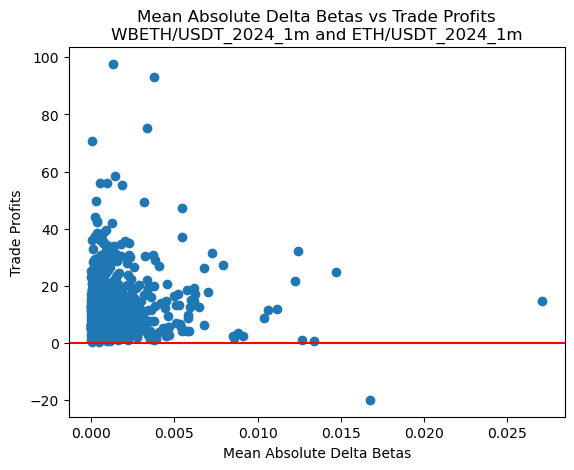

In [108]:
plt.scatter(mean_absolute_delta_betas, trade_profits)
plt.xlabel('Mean Absolute Delta Betas')
plt.ylabel('Trade Profits')
plt.title(f'Mean Absolute Delta Betas vs Trade Profits\n{sym1} and {sym2}')
plt.axhline(0, color = 'red')

#Save the plot to the results folder for this pair. Create the folder if it doesn't exist.
if not os.path.exists(f"results/{sym1}_{sym2}"):
    os.makedirs(f"results/{sym1}_{sym2}")
#Save the plot
plt.savefig(f"results/{sym1}_{sym2}/Mean_Absolute_Delta_Betas_Vs_Trade_Profits.png", dpi=300)


In [109]:
del range

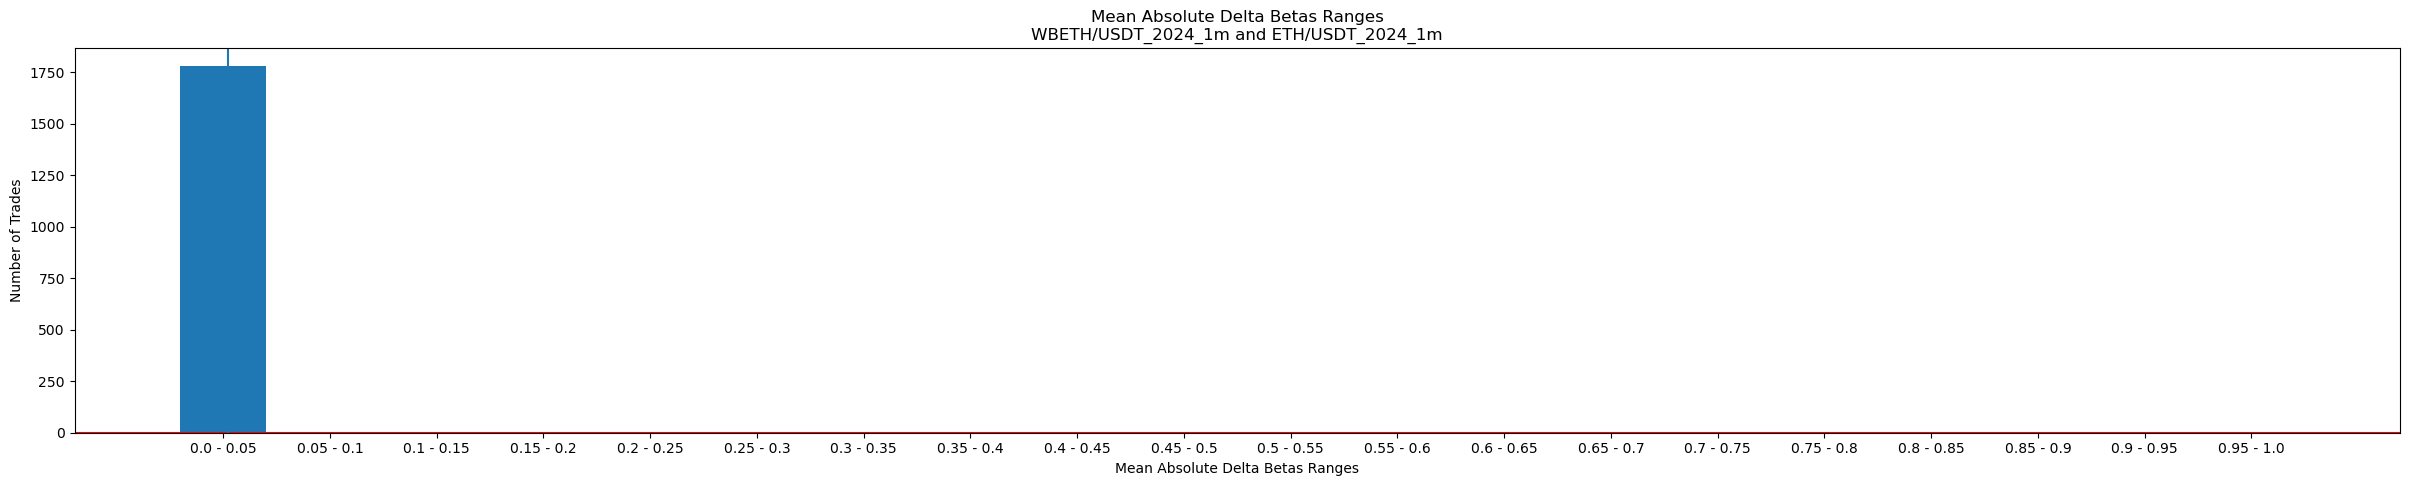

In [110]:
#Create ranges from mean_absolute_delta_betas
ranges = []

for i in range(0, 100, 5):
    ranges.append((i/100, (i+5)/100))

#Count the number of trades where the mean absolute delta beta is in the range
mean_absolute_delta_betas_ranges = []
for i in range(len(ranges)):
    mean_absolute_delta_betas_ranges.append(0)

#Count the number of trades where the mean absolute delta beta is in the range
for mean_absolute_delta_beta in mean_absolute_delta_betas:
    for i in range(len(ranges)):
        if mean_absolute_delta_beta >= ranges[i][0] and mean_absolute_delta_beta < ranges[i][1]:
            mean_absolute_delta_betas_ranges[i] += 1
            break

plt.figure(figsize=(30, 5))
#Plot the ranges
plt.bar(range(len(ranges)), mean_absolute_delta_betas_ranges)
plt.xticks(range(len(ranges)), [f"{ranges[i][0]} - {ranges[i][1]}" for i in range(len(ranges))])
plt.xlabel('Mean Absolute Delta Betas Ranges')
plt.ylabel('Number of Trades')
plt.title(f'Mean Absolute Delta Betas Ranges\n{sym1} and {sym2}')
plt.axhline(0, color = 'red')
plt.axvline(0.05)

#Save the plot to the results folder for this pair. Create the folder if it doesn't exist.
if not os.path.exists(f"results/{sym1}_{sym2}"):
    os.makedirs(f"results/{sym1}_{sym2}")
#Save the plot
plt.savefig(f"results/{sym1}_{sym2}/Mean_Absolute_Delta_Betas_Ranges.png", dpi=300)

In [111]:
trades_data = list(zip(trade_profits,mean_absolute_delta_betas))

trade_win_rates = []
probability_of_losses = []

for range in ranges:
    trade_wins = 0
    trade_losses = 0
    probability_of_loss = 0
    for trade_data in trades_data:
        if trade_data[1] >= range[0] and trade_data[1] < range[1]:
            if trade_data[0] > 0:
                trade_wins += 1
            else:
                trade_losses += 1
    if trade_wins + trade_losses > 0:
        trade_wins_percentage = trade_wins / (trade_wins + trade_losses) * 100
        probability_of_loss = trade_losses / (trade_wins + trade_losses) * 100
        print(f"Range: {range[0]} - {range[1]}, Trade wins: {trade_wins}, Trade losses: {trade_losses}, Probability of loss: {probability_of_loss:.2f}%")
        
    trade_win_rates.append(trade_wins_percentage)
    probability_of_losses.append(probability_of_loss)
    


 
    

    

Range: 0.0 - 0.05, Trade wins: 1778, Trade losses: 1, Probability of loss: 0.06%


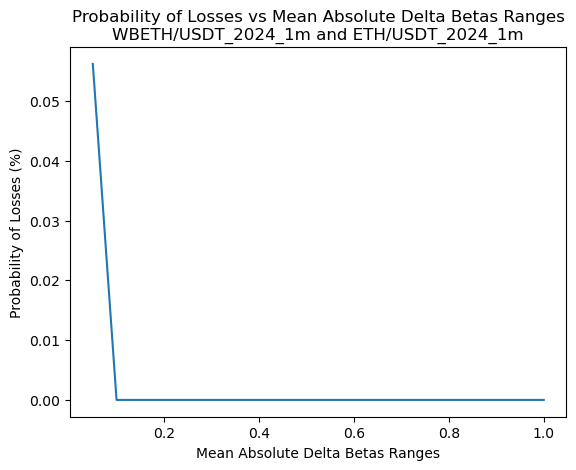

In [112]:
#Plot trade ranges and probability of losses on bar chart

range_ends = [full_range[1] for full_range in ranges]

plt.plot(range_ends, probability_of_losses, label='Probability of Losses')
plt.xlabel('Mean Absolute Delta Betas Ranges')
plt.ylabel('Probability of Losses (%)')
plt.title(f'Probability of Losses vs Mean Absolute Delta Betas Ranges\n{sym1} and {sym2}')
#Plot the ranges

#Save the plot to the results folder for this pair. Create the folder if it doesn't exist.
if not os.path.exists(f"results/{sym1}_{sym2}"):
    os.makedirs(f"results/{sym1}_{sym2}")
#Save the plot
plt.savefig(f"results/{sym1}_{sym2}/Probability_of_Losses_Vs_Mean_Absolute_Delta_Betas_Ranges.png", dpi=300)



In [113]:
mean_absolute_delta_betas_ranges

[1779, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Findings From Study
----

In [114]:
#Create dataframe to store key metrics:


trade_losses = [profit for profit in trade_profits if profit < 0]
trade_wins = [profit for profit in trade_profits if profit > 0]
non_stop_loss_win_rate = len(trade_wins) / (len(trade_wins) + len(trade_losses)) * 100


mean_trade_duration = np.mean(trade_durations)
average_absolute_delta_beta = np.mean(mean_absolute_delta_betas)
average_S1_trade_returns = np.mean(S1_trade_returns)
average_S2_trade_returns = np.mean(S2_trade_returns)


key_metrics = pd.DataFrame({
    'Pair': f"{sym1} ~ {sym2}",
    'Total return (%)': cumulative_profit_series[-1]/initial_capital * 100,
    'Number of trades': len(trade_profits),
    'Non-stop loss win rate (%)': non_stop_loss_win_rate,
    'Mean trade duration': mean_trade_duration,
    'Average entry beta': avg_beta,
    'Mean Absolute Delta Beta': average_absolute_delta_beta,
    'Beta series returns std (%)': std_beta_series,
    'Spread series z-score std (%)': z_score_spread_std,
    'Average S1 trade returns (%)': average_S1_trade_returns,
    'Average S2 trade returns (%)': average_S2_trade_returns,
},index=[0])

#Save key metrics to csv
key_metrics.to_csv(f'results/{sym1}_{sym2}/key_metrics.csv', index=False)

/var/folders/rc/tn2ys5g55157vhhlmn0_vfwr0000gq/T/ipykernel_53145/3231975130.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Total return (%)': cumulative_profit_series[-1]/initial_capital * 100,


In [115]:
key_metrics

,Pair,Total return (%),Number of trades,Non-stop loss win rate (%),Mean trade duration,Average entry beta,Mean Absolute Delta Beta,Beta series returns std (%),Spread series z-score std (%),Average S1 trade returns (%),Average S2 trade returns (%)
0,WBETH/USDT_2024_1m ~ ETH/USDT_2024_1m,201.38789,1779,99.943789,5.405846,1.03438,0.000837,0.020864,1.030477,-0.026812,0.02377


In [116]:
#Losses are due to errors in Beta estimation. Prices move more or less than expected under the estimated ratio, leaving you unhedged.
#Large gains and losses are due to increased volatility in each asset. Larger swings in price lead to larger profits and losses.

#Conversely, if the pair is less tightly linked (or if the cointegration relationship temporarily weakens), both the idiosyncrasies in the raw prices and the increased uncertainty in β will contribute to a more volatile spread


#SO FAR, WE HAVE REVERSION TIME, VOLATILITY OF SPREAD, AND VARIANCE OF BETA SERIES RETURNS, AND 

In [117]:
# THE LESS DELTA NEUTRAL YOU ARE IN A TRADE, THE MORE LIKELY THAT TRADE WILL BE A LOSS (SURELY)